# Bodypix prediction

Stackoverflow on how to convert tf_js  models :

https://stackoverflow.com/questions/55605213/how-to-convert-the-body-pix-models-for-tfjs-to-keras-h5-or-tensorflow-frozen-gra

tf_js converter

https://github.com/patlevin/tfjs-to-tf

Example posenet :

https://github.com/ajaichemmanam/posenetv2-pythontf/blob/master/TFJS%20Model%20URL

Body-pix on github :

https://github.com/tensorflow/tfjs-models/tree/ea1c3dca675221c8d86fa4db9e35214069cb80e3/body-pix

Retrieve model :

* https://stackoverflow.com/questions/50632258/how-to-restore-tensorflow-model-from-pb-file-in-python
* https://stackoverflow.com/questions/46127471/how-to-get-weights-from-pb-model-in-tensorflow

Example of posenet used in python :
* https://github.com/rwightman/posenet-python

Credit to :
* https://github.com/ajaichemmanam/simple_bodypix_python

## Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
from PIL import Image
from utils import load_graph_model, get_input_tensors, get_output_tensors
import tensorflow as tf
# make tensorflow stop spamming messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"


# PATHS
imagePath = 'input_images/homme.jpg'
modelPath = 'model_bodypix/model.json'

# CONSTANTS
OutputStride = 16

KEYPOINT_NAMES = [
    "nose", "leftEye", "rightEye", "leftEar", "rightEar", "leftShoulder",
    "rightShoulder", "leftElbow", "rightElbow", "leftWrist", "rightWrist",
    "leftHip", "rightHip", "leftKnee", "rightKnee", "leftAnkle", "rightAnkle"
]


KEYPOINT_IDS = {name: id for id, name in enumerate(KEYPOINT_NAMES)}

CONNECTED_KEYPOINTS_NAMES = [
    ("leftHip", "leftShoulder"), ("leftElbow", "leftShoulder"),
    ("leftElbow", "leftWrist"), ("leftHip", "leftKnee"),
    ("leftKnee", "leftAnkle"), ("rightHip", "rightShoulder"),
    ("rightElbow", "rightShoulder"), ("rightElbow", "rightWrist"),
    ("rightHip", "rightKnee"), ("rightKnee", "rightAnkle"),
    ("leftShoulder", "rightShoulder"), ("leftHip", "rightHip")
]

CONNECTED_KEYPOINT_INDICES = [(KEYPOINT_IDS[a], KEYPOINT_IDS[b])
                              for a, b in CONNECTED_KEYPOINTS_NAMES]

PART_CHANNELS = [
                'left_face',
                'right_face',
                'left_upper_arm_front',
                'left_upper_arm_back',
                'right_upper_arm_front',
                'right_upper_arm_back',
                'left_lower_arm_front',
                'left_lower_arm_back',
                'right_lower_arm_front',
                'right_lower_arm_back',
                'left_hand',
                'right_hand',
                'torso_front',
                'torso_back',
                'left_upper_leg_front',
                'left_upper_leg_back',
                'right_upper_leg_front',
                'right_upper_leg_back',
                'left_lower_leg_front',
                'left_lower_leg_back',
                'right_lower_leg_front',
                'right_lower_leg_back',
                'left_feet',
                'right_feet'
                ]

print("Loading model...", end="")
graph = load_graph_model(modelPath)  # downloaded from the link above
print("done.\nLoading sample image...", end="")

Loading model...done.
Loading sample image...

In [2]:
def getBoundingBox(keypointPositions, offset=(10, 10, 10, 10)):
    minX = math.inf
    minY = math.inf
    maxX = - math.inf
    maxY = -math.inf
    for x, y in keypointPositions:
        if (x < minX):
            minX = x
        if(y < minY):
            minY = y
        if(x > maxX):
            maxX = x
        if (y > maxY):
            maxY = y
    return (minX - offset[0], minY-offset[1]), (maxX+offset[2], maxY + offset[3])

In [39]:
def get_segment_from_image_path(imagePath, graph):
    # load sample image into numpy array
    img = tf.keras.preprocessing.image.load_img(imagePath)
    imgWidth, imgHeight = img.size

    targetWidth = (int(imgWidth) // OutputStride) * OutputStride + 1
    targetHeight = (int(imgHeight) // OutputStride) * OutputStride + 1

    print(imgHeight, imgWidth, targetHeight, targetWidth)
    img = img.resize((targetWidth, targetHeight))
    x = tf.keras.preprocessing.image.img_to_array(img, dtype=np.float32)
    InputImageShape = x.shape
    print("Input Image Shape in hwc", InputImageShape)


    widthResolution = int((InputImageShape[1] - 1) / OutputStride) + 1
    heightResolution = int((InputImageShape[0] - 1) / OutputStride) + 1
    print('Resolution', widthResolution, heightResolution)

    # Get input and output tensors
    input_tensor_names = get_input_tensors(graph)
    print(input_tensor_names)
    output_tensor_names = get_output_tensors(graph)
    print(output_tensor_names)
    input_tensor = graph.get_tensor_by_name(input_tensor_names[0])

    # Preprocessing Image
    # For Resnet
    if any('resnet_v1' in name for name in output_tensor_names):
        # add imagenet mean - extracted from body-pix source
        m = np.array([-123.15, -115.90, -103.06])
        x = np.add(x, m)
    # For Mobilenet
    elif any('MobilenetV1' in name for name in output_tensor_names):
        x = (x/127.5)-1
    else:
        print('Unknown Model')
    sample_image = x[tf.newaxis, ...]
    print("done.\nRunning inference...", end="")

    # evaluate the loaded model directly
    with tf.compat.v1.Session(graph=graph) as sess:
        results = sess.run(output_tensor_names, feed_dict={
                           input_tensor: sample_image})
    print("done. {} outputs received".format(len(results)))  # should be 8 outputs

    for idx, name in enumerate(output_tensor_names):
        if 'displacement_bwd' in name:
            print('displacement_bwd', results[idx].shape)
        elif 'displacement_fwd' in name:
            print('displacement_fwd', results[idx].shape)
        elif 'float_heatmaps' in name:
            heatmaps = np.squeeze(results[idx], 0)
            print('heatmaps', heatmaps.shape)
        elif 'float_long_offsets' in name:
            longoffsets = np.squeeze(results[idx], 0)
            print('longoffsets', longoffsets.shape)
        elif 'float_short_offsets' in name:
            offsets = np.squeeze(results[idx], 0)
            print('offests', offsets.shape)
        elif 'float_part_heatmaps' in name:
            partHeatmaps = np.squeeze(results[idx], 0)
            print('partHeatmaps', partHeatmaps.shape)
        elif 'float_segments' in name:
            segments = np.squeeze(results[idx], 0)
            print('segments', segments.shape)
        elif 'float_part_offsets' in name:
            partOffsets = np.squeeze(results[idx], 0)
            print('partOffsets', partOffsets.shape)
        else:
            print('Unknown Output Tensor', name, idx)


    # BODYPART SEGMENTATION
    partOffsetVector = []
    partHeatmapPositions = []
    partPositions = []
    partScores = []
    partMasks = []

    # Segmentation MASk
    segmentation_threshold = 0.2
    segmentScores = tf.sigmoid(segments)
    mask = tf.math.greater(segmentScores, tf.constant(segmentation_threshold))
    print('maskshape', mask.shape)
    
    return mask, targetWidth, targetHeight, partHeatmaps, img, heatmaps, offsets

In [40]:
mask, targetWidth, targetHeight, partHeatmaps, img, heatmaps, offsets = get_segment_from_image_path(imagePath, graph)

449 325 449 321
Input Image Shape in hwc (449, 321, 3)
Resolution 21 29
['sub_2:0']
['resnet_v1_50/displacement_bwd_2/BiasAdd:0', 'resnet_v1_50/displacement_fwd_2/BiasAdd:0', 'float_heatmaps:0', 'float_long_offsets:0', 'float_short_offsets:0', 'float_part_heatmaps:0', 'float_segments:0', 'float_part_offsets:0']
done.
Running inference...done. 8 outputs received
displacement_bwd (1, 29, 21, 32)
displacement_fwd (1, 29, 21, 32)
heatmaps (29, 21, 17)
longoffsets (29, 21, 34)
offests (29, 21, 34)
partHeatmaps (29, 21, 24)
segments (29, 21, 1)
partOffsets (29, 21, 48)
maskshape (29, 21, 1)


# Whole body

maskValue [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0]


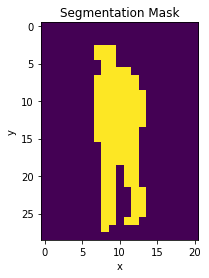

In [5]:
def get_segmentation_mask(mask):
    segmentationMask = tf.dtypes.cast(mask, tf.int32)
    segmentationMask = np.reshape(
        segmentationMask, (segmentationMask.shape[0], segmentationMask.shape[1]))
    
    return segmentationMask

segmentationMask = get_segmentation_mask(mask)

print('maskValue', segmentationMask[:][:])

plt.clf()
plt.title('Segmentation Mask')
plt.ylabel('y')
plt.xlabel('x')
plt.imshow(segmentationMask * OutputStride)
plt.show()

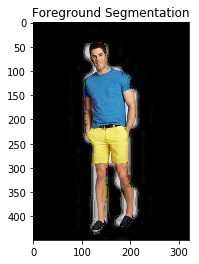

In [6]:
# Draw Segmented Output

mask_img = Image.fromarray(segmentationMask * 255)
mask_img = mask_img.resize(
    (targetWidth, targetHeight), Image.LANCZOS).convert("RGB")
mask_img = tf.keras.preprocessing.image.img_to_array(
    mask_img, dtype=np.uint8)

segmentationMask_inv = np.bitwise_not(mask_img)
fg = np.bitwise_and(np.array(img), np.array(
    mask_img))
plt.title('Foreground Segmentation')
plt.imshow(fg)
plt.show()

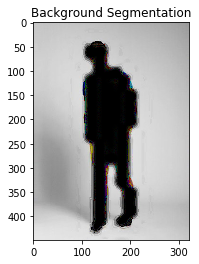

In [21]:
bg = np.bitwise_and(np.array(img), np.array(
    segmentationMask_inv))
plt.title('Background Segmentation')
plt.imshow(bg)
plt.show()

# Body segmentation

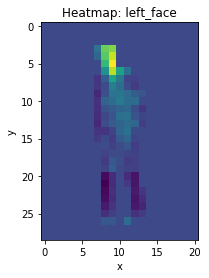

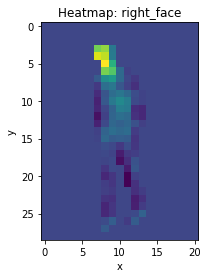

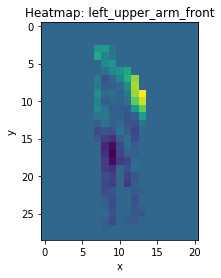

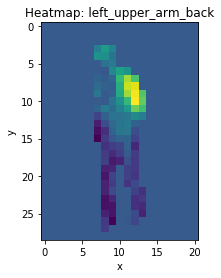

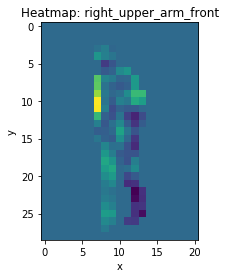

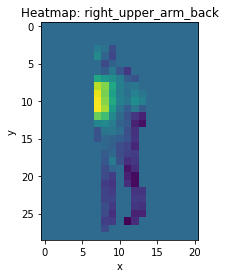

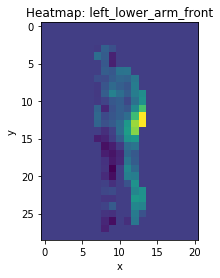

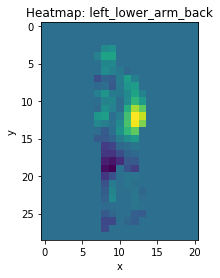

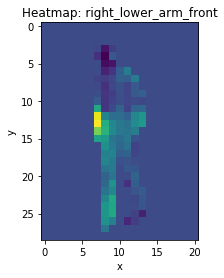

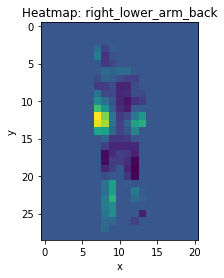

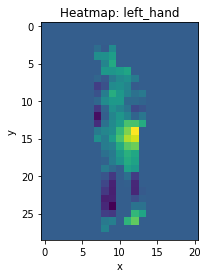

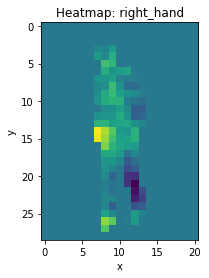

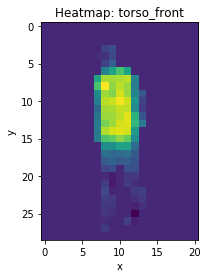

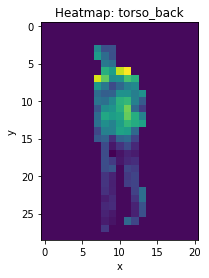

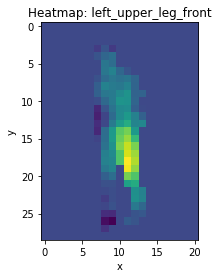

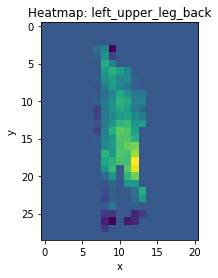

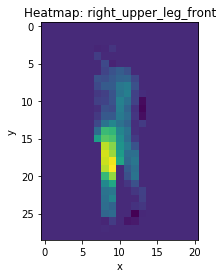

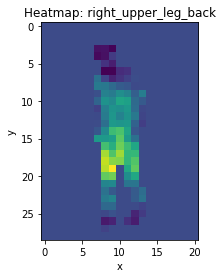

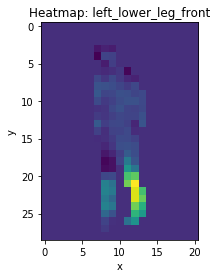

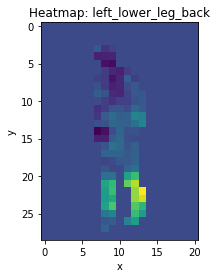

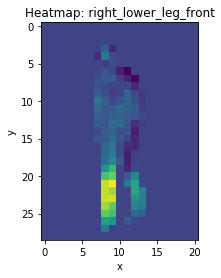

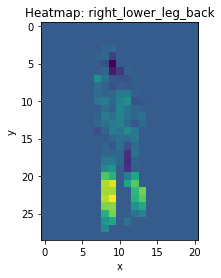

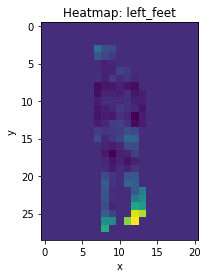

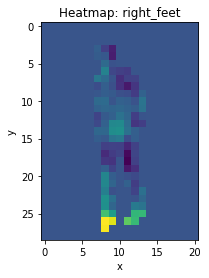

In [120]:
# Part Heatmaps, PartOffsets,
for i in range(partHeatmaps.shape[2]):

    heatmap = partHeatmaps[:, :, i]  # First Heat map
    heatmap[np.logical_not(tf.math.reduce_any(mask, axis=-1).numpy())] = -1
    # Set portions of heatmap where person is not present in segmentation mask, set value to -1

    # SHOW HEATMAPS

    plt.clf()
    plt.title('Heatmap: ' + PART_CHANNELS[i])
    plt.ylabel('y')
    plt.xlabel('x')
    plt.imshow(heatmap * OutputStride)
    plt.show()

    heatmap_sigmoid = tf.sigmoid(heatmap)
    y_heat, x_heat = np.unravel_index(
        np.argmax(heatmap_sigmoid, axis=None), heatmap_sigmoid.shape)

    partHeatmapPositions.append([x_heat, y_heat])
    partScores.append(heatmap_sigmoid[y_heat, x_heat].numpy())
    # Offset Corresponding to heatmap x and y
    x_offset = partOffsets[y_heat, x_heat, i]
    y_offset = partOffsets[y_heat, x_heat, partHeatmaps.shape[2]+i]
    partOffsetVector.append([x_offset, y_offset])

    key_x = x_heat * OutputStride + x_offset
    key_y = y_heat * OutputStride + y_offset
    partPositions.append([key_x, key_y])

In [9]:
def get_num_from_part(part_name):
    i=0
    for i in range(len(PART_CHANNELS)):
        if PART_CHANNELS[i] == part_name:
            return i
        i += 1

In [10]:
def resize_and_inverse_mask(mask):
    mask = Image.fromarray(np.array(tf.dtypes.cast(mask, tf.int32)) * 255)
    mask = np.array(tf.dtypes.cast(mask, tf.int32))
    mask = mask.resize((targetWidth, targetHeight), Image.LANCZOS).convert("RGB")
    mask_inv = np.bitwise_not(mask)
    
    return mask_inv

In [11]:
def resize_mask(mask, targetWidth, targetHeight):
    mask = Image.fromarray(np.array(tf.dtypes.cast(mask, tf.int32)) * 255)
    mask = mask.resize((targetWidth, targetHeight), Image.LANCZOS).convert("RGB")
    mask = np.array(mask)/255
    return mask

In [12]:
def get_mask_area(area_name, partHeatmaps):
    i = get_num_from_part(area_name)
    mask = np.array(np.argmax(partHeatmaps, axis=2)==i, dtype=int)
    #torso_front = partHeatmaps[:, :, i]  # First Heat map
    mask[np.logical_not(tf.math.reduce_any(mask, axis=-1).numpy())] = -1
    mask = resize_mask(mask, targetWidth, targetHeight)
    #mask = Image.fromarray(np.array(tf.dtypes.cast(mask, tf.int32)) * 255)
    #mask = mask.resize((targetWidth, targetHeight), Image.LANCZOS).convert("RGB")
    #mask_inv = np.bitwise_not(mask)
    return mask

In [13]:
def get_mask_for_body_parts(segmentationMask, targetWidth, targetHeight, partHeatmaps, body_parts = ['left_upper_arm_front',
                                                                                      'left_upper_arm_back',
                                                                                      'right_upper_arm_front',
                                                                                      'right_upper_arm_back',
                                                                                      'left_lower_arm_front',
                                                                                      'left_lower_arm_back',
                                                                                      'right_lower_arm_front',
                                                                                      'right_lower_arm_back',
                                                                                      'torso_front',
                                                                                      'torso_back']):
    
    mask_body = resize_mask(segmentationMask, targetWidth, targetHeight)
    mask = np.zeros(mask_body.shape)

    for body_part in body_parts:
        mask += mask_body * get_mask_area(body_part, partHeatmaps)
    
    return mask

In [19]:
import cv2
import numpy as np

def img_with_colored_mask(mask_body_part, mask_body, img, color = [255, 135, 135], threshold = 0.4):

    mask_bin = np.where(mask_body_part < threshold, 0, 1)
    mask_bin_inv = np.where(mask_body_part < threshold, 1, 0)
    
    array_color = np.zeros((mask_body.shape[0], mask_body.shape[1], 3))
    for i in range(mask_body.shape[0]):
        for j in range(mask_body.shape[1]):
            array_color[i, j, :] = color

    img_colored = cv2.addWeighted(array_color, 0.5, np.array(img, dtype=float), 0.2, 0)
    img_with_color_mask = img_colored * mask_bin + np.array(img, dtype=float) * mask_bin_inv
    img_with_color_mask = np.array(img_with_color_mask, dtype=int)
    
    return img_with_color_mask

In [20]:
def get_mask_img(segmentationMask):
    
    mask_img = Image.fromarray(segmentationMask * 255)
    mask_img = mask_img.resize(
        (targetWidth, targetHeight), Image.LANCZOS).convert("RGB")
    mask_img = tf.keras.preprocessing.image.img_to_array(
        mask_img, dtype=np.uint8)
    
    return mask_img

In [ ]:
PART_CHANNELS = [
    'left_face',
    'right_face',
    'left_upper_arm_front',
    'left_upper_arm_back',
    'right_upper_arm_front',
    'right_upper_arm_back',
    'left_lower_arm_front',
    'left_lower_arm_back',
    'right_lower_arm_front',
    'right_lower_arm_back',
    'left_hand',
    'right_hand',
    'torso_front',
    'torso_back',
    'left_upper_leg_front',
    'left_upper_leg_back',
    'right_upper_leg_front',
    'right_upper_leg_back',
    'left_lower_leg_front',
    'left_lower_leg_back',
    'right_lower_leg_front',
    'right_lower_leg_back',
    'left_feet',
    'right_feet'
]

In [68]:
mask_body_part = get_mask_for_body_parts(segmentationMask, targetWidth, 
                                         targetHeight, partHeatmaps,
                                         # body_parts = ['left_face', 'right_face']
                                         body_parts = [
                                                       'left_upper_arm_front',
                                                       'left_upper_arm_back',
                                                       'right_upper_arm_front',
                                                       'right_upper_arm_back',
                                                       #'left_lower_arm_front',
                                                       #'left_lower_arm_back',
                                                       #'right_lower_arm_front',
                                                       #'right_lower_arm_back',
                                                       'torso_front',
                                                       'torso_back']
                                        )

mask_img = get_mask_img(segmentationMask)
img_with_color_mask = img_with_colored_mask(mask_body_part, mask_img, img, color = [255, 135, 135], threshold = 0.6)

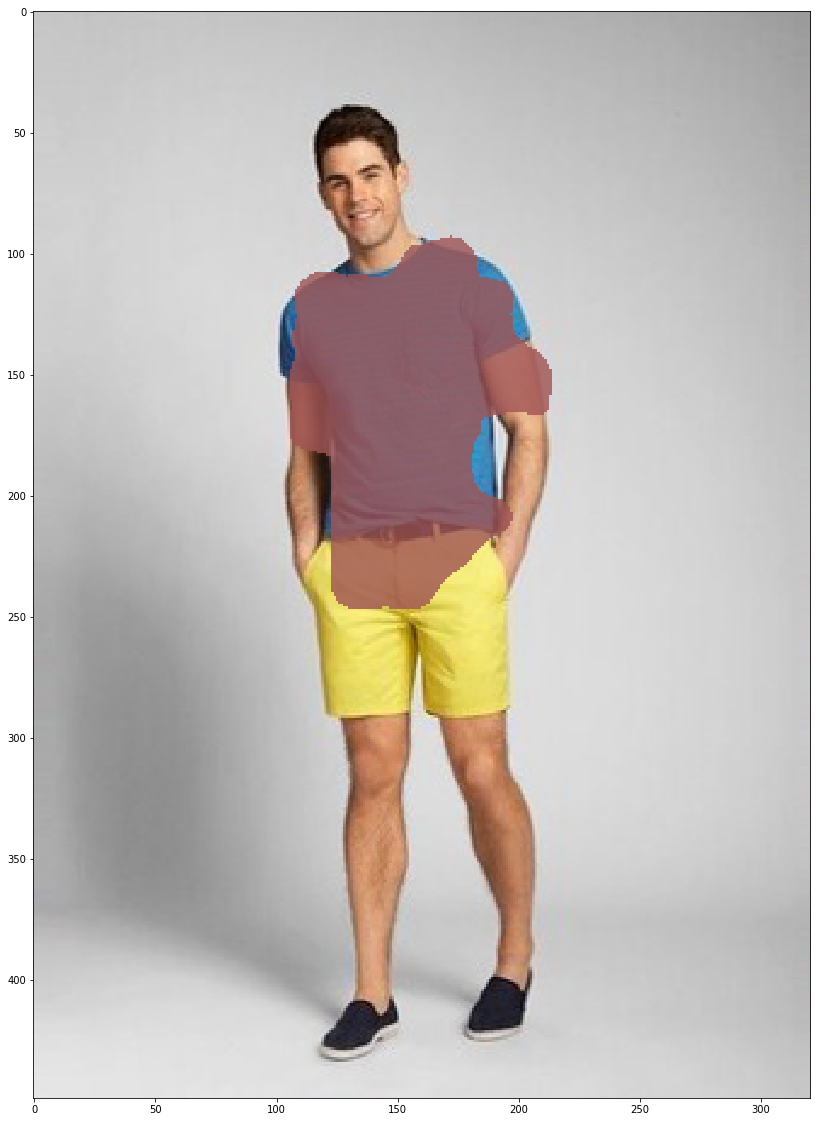

In [69]:
plt.figure(figsize=(20,20))
plt.imshow(img_with_color_mask)

In [46]:
heatmap_sigmoid

<tf.Tensor: id=873, shape=(29, 21), dtype=float32, numpy=
array([[1.43647194e-04, 8.69333744e-05, 1.05589628e-04, 5.65946102e-05,
        5.16772270e-05, 3.09348106e-05, 9.08970833e-06, 6.31809235e-06,
        4.82797623e-06, 3.66568565e-06, 5.72204590e-06, 1.52289867e-05,
        2.19941139e-05, 3.37660313e-05, 2.02953815e-05, 2.11596489e-05,
        2.62558460e-05, 3.27527523e-05, 4.45544720e-05, 3.78489494e-05,
        1.29491091e-04],
       [6.94990158e-05, 7.96020031e-05, 9.38773155e-05, 4.56869602e-05,
        5.51044941e-05, 1.56164169e-05, 2.62260437e-05, 8.04662704e-06,
        1.49309635e-05, 1.34408474e-05, 2.00867653e-05, 3.52859497e-05,
        2.06530094e-05, 2.25007534e-05, 1.71959400e-05, 1.89244747e-05,
        1.95503235e-05, 1.89542770e-05, 3.64482403e-05, 2.01165676e-05,
        1.01059675e-04],
       [1.35302544e-05, 1.25169754e-05, 7.12275505e-06, 1.96695328e-06,
        1.04308128e-06, 1.01327896e-06, 8.16583633e-06, 2.61664391e-05,
        7.02738762e-05, 1.47

In [49]:
CONNECTED_KEYPOINT_INDICES

[(11, 5),
 (7, 5),
 (7, 9),
 (11, 13),
 (13, 15),
 (12, 6),
 (8, 6),
 (8, 10),
 (12, 14),
 (14, 16),
 (5, 6),
 (11, 12)]

In [70]:
KEYPOINT_NAMES

['nose',
 'leftEye',
 'rightEye',
 'leftEar',
 'rightEar',
 'leftShoulder',
 'rightShoulder',
 'leftElbow',
 'rightElbow',
 'leftWrist',
 'rightWrist',
 'leftHip',
 'rightHip',
 'leftKnee',
 'rightKnee',
 'leftAnkle',
 'rightAnkle']

In [75]:
def get_key_points(heatmaps):
    # POSE ESTIMATION
    offsetVector = []
    heatmapPositions = []
    keypointPositions = []
    keyScores = []
    for i in range(heatmaps.shape[2]):
        heatmap = heatmaps[:, :, i]  # First Heat map
        # SHOW HEATMAPS
        '''
        plt.clf()
        plt.title('Heatmap' + str(i) + KEYPOINT_NAMES[i])
        plt.ylabel('y')
        plt.xlabel('x')
        plt.imshow(heatmap * OutputStride)
        plt.show()
        '''

        heatmap_sigmoid = tf.sigmoid(heatmap)
        y_heat, x_heat = np.unravel_index(
            np.argmax(heatmap_sigmoid, axis=None), heatmap_sigmoid.shape)

        heatmapPositions.append([x_heat, y_heat])
        keyScores.append(heatmap_sigmoid[y_heat, x_heat].numpy())
        # Offset Corresponding to heatmap x and y
        x_offset = offsets[y_heat, x_heat, i]
        y_offset = offsets[y_heat, x_heat, heatmaps.shape[2]+i]

        offsetVector.append([x_offset, y_offset])
        key_x = x_heat * OutputStride + x_offset
        key_y = y_heat * OutputStride + y_offset
        keypointPositions.append([key_x, key_y])
    
    return keypointPositions, keyScores

In [76]:
keypointsPositions, keyScores = get_key_points(heatmaps)

In [77]:
def get_position_keypoint(name, KEYPOINT_NAMES):
    for i in range(len(KEYPOINT_NAMES)):
        if KEYPOINT_NAMES[i]==name:
            return i

In [78]:
KEYPOINT_NAMES

['nose',
 'leftEye',
 'rightEye',
 'leftEar',
 'rightEar',
 'leftShoulder',
 'rightShoulder',
 'leftElbow',
 'rightElbow',
 'leftWrist',
 'rightWrist',
 'leftHip',
 'rightHip',
 'leftKnee',
 'rightKnee',
 'leftAnkle',
 'rightAnkle']

In [82]:
position_name = "leftShoulder"
def get_position_from_position_name(position_name, KEYPOINT_NAMES, keypointsPositions):
    num = get_position_keypoint(position_name, KEYPOINT_NAMES)
    return keypointsPositions[num]

heatmapPositions (17, 2)
offsetVector (17, 2)
keypointPositions (17, 2)
keyScores (17,)
Keypoint Confidence Score
nose 0.9991943
leftEye 0.99904466
rightEye 0.9989163
leftEar 0.98061633
rightEar 0.8843365
leftShoulder 0.99628353
rightShoulder 0.99844205
leftElbow 0.9949473
rightElbow 0.9973167
leftWrist 0.99148
rightWrist 0.98884153
leftHip 0.9969018
rightHip 0.99366605
leftKnee 0.99845254
rightKnee 0.998337
leftAnkle 0.9869524
rightAnkle 0.98740697
Pose Confidence Score 0.9877139
Bounding Box xmin, ymin, xmax, ymax format:  91.89070320129395 70.53173732757568 204.54204487800598 406.9195704460144


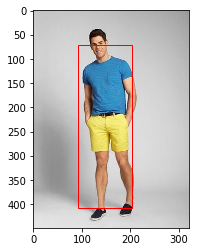

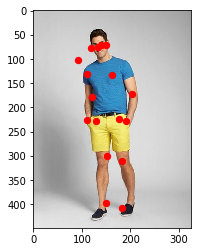

<Figure size 432x288 with 0 Axes>

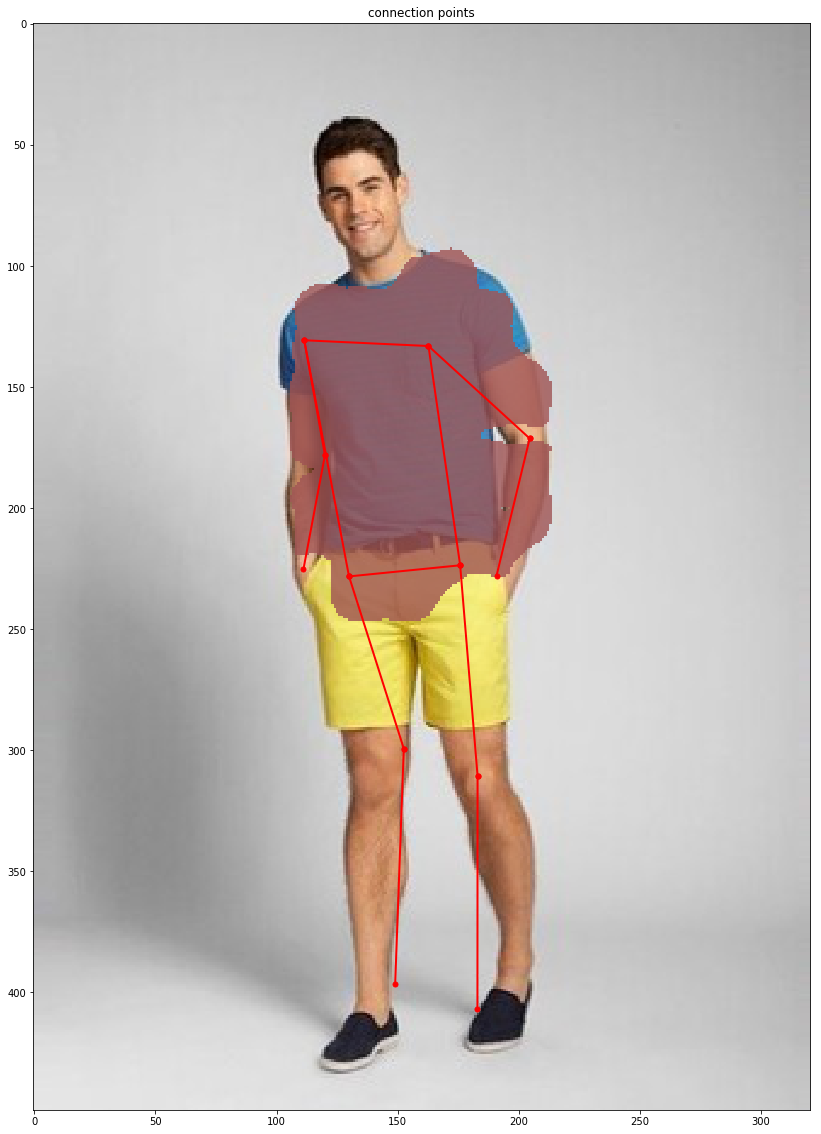

In [44]:
print('heatmapPositions', np.asarray(heatmapPositions).shape)
print('offsetVector', np.asarray(offsetVector).shape)
print('keypointPositions', np.asarray(keypointPositions).shape)
print('keyScores', np.asarray(keyScores).shape)

# PRINT KEYPOINT CONFIDENCE SCORES
print("Keypoint Confidence Score")
for i, score in enumerate(keyScores):
    print(KEYPOINT_NAMES[i], score)

# PRINT POSE CONFIDENCE SCORE
print("Pose Confidence Score", np.mean(np.asarray(keyScores)))

# Get Bounding BOX
(xmin, ymin), (xmax, ymax) = getBoundingBox(
    keypointPositions, offset=(0, 0, 0, 0))
print("Bounding Box xmin, ymin, xmax, ymax format: ", xmin, ymin, xmax, ymax)

# Show Bounding BOX
implot = plt.imshow(img)
# Get the current reference
ax = plt.gca()
# Create a Rectangle patch
rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                         linewidth=1, edgecolor='r', facecolor='none', fill=False)

# Add the patch
ax.add_patch(rect)
plt.show()

# Show all keypoints

plt.figure(0)
im = plt.imread(imagePath)
implot = plt.imshow(im)

x_points = []
y_points = []
for i, [x, y] in enumerate(keypointPositions):
    x_points.append(x)
    y_points.append(y)
plt.scatter(x=x_points, y=y_points, c='r', s=40)
plt.show()


# DEBUG KEYPOINTS
#  Show Each Keypoint and it's name
'''
for i, [x, y] in enumerate(keypointPositions):
    plt.figure(i)
    plt.title('keypoint' + str(i) + KEYPOINT_NAMES[i])
#    img = plt.imread(imagePath)
    implot = plt.imshow(img)
    plt.scatter(x=[x], y=[y], c='r', s=40)
    plt.show()
'''

# SHOW CONNECTED KEYPOINTS
plt.figure(20)
plt.figure(figsize=(20,20))
for pt1, pt2 in CONNECTED_KEYPOINT_INDICES:
    plt.title('connection points')
    implot = plt.imshow(img)
    plt.plot((keypointPositions[pt1][0], keypointPositions[pt2][0]), (
        keypointPositions[pt1][1], keypointPositions[pt2][1]), 'ro-', linewidth=2, markersize=5)

    plt.imshow(img_with_color_mask)
plt.show()